In [1]:
import tensorflow as tf
import os


import sys
# from seq2tensor import s2t
import keras


from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Bidirectional,Multiply 
# Merge, 
from keras.layers import BatchNormalization, merge, add
from keras.layers.core import Flatten, Reshape
from keras.layers.merge import Concatenate, concatenate, subtract, multiply
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.optimizers import Adam,  RMSprop

import keras.backend.tensorflow_backend as KTF

import numpy as np
from tqdm import tqdm
from keras.layers import Input, CuDNNGRU, GRU
from numpy import linalg as LA
import scipy
#from sklearn.model_selection import KFold, ShuffleSplit
from keras import backend as K
import re
#from multiHead import  SparseSelfAttention

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)

2022-01-17 17:53:05.092566: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Using TensorFlow backend.




2022-01-17 17:53:06.000371: I tensorflow/core/platform/cpu_feature_guard.cc:145] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2022-01-17 17:53:06.028385: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2900000000 Hz
2022-01-17 17:53:06.031370: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e56a7b3fb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-17 17:53:06.031397: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-01-17 17:53:06.032640: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-17 17:53:06.060483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:3b:00.0
2022-01-17 17:53:06.0

In [2]:
from keras.layers import Lambda,Add, CuDNNGRU,TimeDistributed, Bidirectional,Softmax
from keras import regularizers
from keras.regularizers import l2
import tensorflow as tf
from keras import regularizers

smilen = 256
hidden_dim = 256


def se_block(input, channels, r=8):
    # Squeeze
    #print("-------")
    x = GlobalAveragePooling1D()(input)
    #print(x.shape)
    # Excitation
    x = Dense(channels//r, activation="relu")(x)
    #print(x.shape)
    x = Dense(channels, activation="sigmoid")(x)
    #print(x.shape)
    #print("-------")
    return Multiply()([input, x])



def conv_block(inputs, seblock, NUM_FILTERS,FILTER_LENGTH1):   
    conv1_encode = Conv1D(filters=NUM_FILTERS, kernel_size=FILTER_LENGTH1,   activation='relu', padding='valid', strides=1)(inputs)
    if seblock: 
        conv1_encode = se_block(conv1_encode,NUM_FILTERS)
    
    return conv1_encode
 
    
def build_model():
    drugInput = Input(shape=(smilen,hidden_dim))
    seblock = True 
    NUM_FILTERS = 2048
    FILTER_LENGTH1 = 1
    n_layers = 4
    
    encode_smiles = conv_block(drugInput, seblock, NUM_FILTERS,FILTER_LENGTH1) 
    encode_smiles = GlobalMaxPooling1D()(encode_smiles) 

    FC1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(encode_smiles)
    
    predictions = Dense(1, kernel_initializer='normal')(FC1) #OR no activation, rght now it's between 0-1, do I want this??? activation='sigmoid'

    interactionModel = Model(inputs=[drugInput], outputs=[predictions])
    #opt = Adam(lr=0.0001)
    interactionModel.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return interactionModel


model = build_model()
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 256, 2048)    526336      input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 2048)         0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          524544      global_average_pooling1d_1[0][0] 
____________________________________________________________________________________________

In [3]:
import numpy as np
embX = np.load(os.path.expanduser('~/fingerprint/encoded-dataset/regression/Malaria_embX_fullBERT.npy'), allow_pickle=True)
newY = np.load(os.path.expanduser('~/fingerprint/encoded-dataset/regression/Malaria_Y_fullBERT.npy'), allow_pickle=True)

X = np.zeros((len(embX), smilen, hidden_dim))
print(X.shape)

for i, x in enumerate(embX):
    if(len(x) > smilen):
        X[i] = x[:smilen]
    else:
        X[i,:len(x)] = x

print(X[0].shape)

(9999, 256, 256)
(256, 256)


In [4]:
from sklearn.model_selection import train_test_split

# train_x, test_x, train_y, test_y = train_test_split(X, newY, test_size=0.1)

# print(train_x.shape)
# print(test_x.shape)
# print(train_y.shape)
# print(test_y.shape)

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

rmses = []
for i in range(5):
    
    train_x, test_x, train_y, test_y = train_test_split(X, newY, test_size=0.1, random_state=42+i)
    save_model_name = f'models-regression-Malaria-TT1-new-{i+1}-50patience-full2'

    model = build_model()

    save_checkpoint = ModelCheckpoint(save_model_name, verbose=1,
                                      save_best_only=True, 
                                      monitor='val_loss', 
                                      save_weights_only=True, mode='min') 
    earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1,mode='min')
    lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25, mode='min', verbose=1)

    model.fit(x=train_x, y=train_y, batch_size=256, epochs=1000, verbose=1, validation_split=0.1111,
                        callbacks=[earlyStopping, save_checkpoint])


    model.load_weights(save_model_name)

    y_pred = model.predict([test_x])

    rmse = mean_squared_error(test_y, y_pred, squared=False)
    print(rmse)
    rmses.append(rmse)


Train on 7999 samples, validate on 1000 samples
Epoch 1/1000
7999/7999 [==============================] - 7s 916us/step - loss: 5.0407 - mean_squared_error: 1.7912 - val_loss: 3.7354 - val_mean_squared_error: 1.5483

Epoch 00001: val_loss improved from inf to 3.73541, saving model to models-regression-Malaria-TT1-new-1-50patience-full2
Epoch 2/1000
7999/7999 [==============================] - 6s 777us/step - loss: 3.1560 - mean_squared_error: 1.3787 - val_loss: 2.9499 - val_mean_squared_error: 1.4887

Epoch 00002: val_loss improved from 3.73541 to 2.94993, saving model to models-regression-Malaria-TT1-new-1-50patience-full2
Epoch 3/1000
7999/7999 [==============================] - 6s 727us/step - loss: 2.5001 - mean_squared_error: 1.2111 - val_loss: 2.4949 - val_mean_squared_error: 1.3745

Epoch 00003: val_loss improved from 2.94993 to 2.49491, saving model to models-regression-Malaria-TT1-new-1-50patience-full2
Epoch 4/1000
7999/7999 [==============================] - 6s 728us/step - 

7999/7999 [==============================] - 6s 711us/step - loss: 0.1466 - mean_squared_error: 0.0965 - val_loss: 1.3977 - val_mean_squared_error: 1.3478

Epoch 00069: val_loss did not improve from 1.29951
Epoch 70/1000
7999/7999 [==============================] - 6s 711us/step - loss: 0.1482 - mean_squared_error: 0.0985 - val_loss: 1.3610 - val_mean_squared_error: 1.3114

Epoch 00070: val_loss did not improve from 1.29951
Epoch 71/1000
7999/7999 [==============================] - 6s 712us/step - loss: 0.1408 - mean_squared_error: 0.0913 - val_loss: 1.3691 - val_mean_squared_error: 1.3197

Epoch 00071: val_loss did not improve from 1.29951
Epoch 72/1000
7999/7999 [==============================] - 6s 704us/step - loss: 0.1239 - mean_squared_error: 0.0746 - val_loss: 1.3698 - val_mean_squared_error: 1.3206

Epoch 00072: val_loss did not improve from 1.29951
Epoch 73/1000
7999/7999 [==============================] - 6s 706us/step - loss: 0.1162 - mean_squared_error: 0.0672 - val_loss: 1

7999/7999 [==============================] - 6s 714us/step - loss: 0.3975 - mean_squared_error: 0.3006 - val_loss: 1.3999 - val_mean_squared_error: 1.3047

Epoch 00026: val_loss did not improve from 1.19345
Epoch 27/1000
7999/7999 [==============================] - 6s 711us/step - loss: 0.4669 - mean_squared_error: 0.3743 - val_loss: 1.1838 - val_mean_squared_error: 1.0932

Epoch 00027: val_loss improved from 1.19345 to 1.18375, saving model to models-regression-Malaria-TT1-new-2-50patience-full2
Epoch 28/1000
7999/7999 [==============================] - 6s 710us/step - loss: 0.3228 - mean_squared_error: 0.2328 - val_loss: 1.3981 - val_mean_squared_error: 1.3087

Epoch 00028: val_loss did not improve from 1.18375
Epoch 29/1000
7999/7999 [==============================] - 6s 708us/step - loss: 0.3652 - mean_squared_error: 0.2767 - val_loss: 1.2777 - val_mean_squared_error: 1.1904

Epoch 00029: val_loss did not improve from 1.18375
Epoch 30/1000
7999/7999 [==============================]

7999/7999 [==============================] - 6s 777us/step - loss: 0.1138 - mean_squared_error: 0.0542 - val_loss: 1.2324 - val_mean_squared_error: 1.1730

Epoch 00063: val_loss did not improve from 1.18375
Epoch 64/1000
7999/7999 [==============================] - 6s 785us/step - loss: 0.1430 - mean_squared_error: 0.0839 - val_loss: 1.2871 - val_mean_squared_error: 1.2285

Epoch 00064: val_loss did not improve from 1.18375
Epoch 65/1000
7999/7999 [==============================] - 6s 765us/step - loss: 0.1717 - mean_squared_error: 0.1136 - val_loss: 1.2678 - val_mean_squared_error: 1.2101

Epoch 00065: val_loss did not improve from 1.18375
Epoch 66/1000
7999/7999 [==============================] - 6s 765us/step - loss: 0.1872 - mean_squared_error: 0.1300 - val_loss: 1.2233 - val_mean_squared_error: 1.1664

Epoch 00066: val_loss did not improve from 1.18375
Epoch 67/1000
7999/7999 [==============================] - 6s 801us/step - loss: 0.1469 - mean_squared_error: 0.0902 - val_loss: 1


Epoch 00018: val_loss did not improve from 1.20401
Epoch 19/1000
7999/7999 [==============================] - 6s 725us/step - loss: 0.6708 - mean_squared_error: 0.5233 - val_loss: 1.2551 - val_mean_squared_error: 1.1112

Epoch 00019: val_loss did not improve from 1.20401
Epoch 20/1000
7999/7999 [==============================] - 5s 673us/step - loss: 0.5655 - mean_squared_error: 0.4239 - val_loss: 1.1927 - val_mean_squared_error: 1.0528

Epoch 00020: val_loss improved from 1.20401 to 1.19273, saving model to models-regression-Malaria-TT1-new-3-50patience-full2
Epoch 21/1000
7999/7999 [==============================] - 6s 727us/step - loss: 0.4944 - mean_squared_error: 0.3555 - val_loss: 1.1750 - val_mean_squared_error: 1.0370

Epoch 00021: val_loss improved from 1.19273 to 1.17502, saving model to models-regression-Malaria-TT1-new-3-50patience-full2
Epoch 22/1000
7999/7999 [==============================] - 6s 725us/step - loss: 0.4578 - mean_squared_error: 0.3208 - val_loss: 1.1826 -

7999/7999 [==============================] - 5s 675us/step - loss: 0.2191 - mean_squared_error: 0.1362 - val_loss: 1.1727 - val_mean_squared_error: 1.0902

Epoch 00055: val_loss did not improve from 1.16485
Epoch 56/1000
7999/7999 [==============================] - 6s 732us/step - loss: 0.1789 - mean_squared_error: 0.0965 - val_loss: 1.2195 - val_mean_squared_error: 1.1373

Epoch 00056: val_loss did not improve from 1.16485
Epoch 57/1000
7999/7999 [==============================] - 5s 675us/step - loss: 0.1999 - mean_squared_error: 0.1182 - val_loss: 1.1861 - val_mean_squared_error: 1.1050

Epoch 00057: val_loss did not improve from 1.16485
Epoch 58/1000
7999/7999 [==============================] - 6s 734us/step - loss: 0.2256 - mean_squared_error: 0.1449 - val_loss: 1.1710 - val_mean_squared_error: 1.0910

Epoch 00058: val_loss did not improve from 1.16485
Epoch 59/1000
7999/7999 [==============================] - 5s 673us/step - loss: 0.1915 - mean_squared_error: 0.1121 - val_loss: 1

7999/7999 [==============================] - 5s 634us/step - loss: 0.1187 - mean_squared_error: 0.0715 - val_loss: 1.1570 - val_mean_squared_error: 1.1099

Epoch 00127: val_loss did not improve from 1.14973
Epoch 128/1000
7999/7999 [==============================] - 5s 687us/step - loss: 0.0857 - mean_squared_error: 0.0386 - val_loss: 1.3853 - val_mean_squared_error: 1.3383

Epoch 00128: val_loss did not improve from 1.14973
Epoch 129/1000
7999/7999 [==============================] - 5s 645us/step - loss: 0.2058 - mean_squared_error: 0.1591 - val_loss: 1.1604 - val_mean_squared_error: 1.1134

Epoch 00129: val_loss did not improve from 1.14973
Epoch 130/1000
7999/7999 [==============================] - 6s 699us/step - loss: 0.1379 - mean_squared_error: 0.0916 - val_loss: 1.1497 - val_mean_squared_error: 1.1037

Epoch 00130: val_loss did not improve from 1.14973
Epoch 131/1000
7999/7999 [==============================] - 5s 641us/step - loss: 0.0851 - mean_squared_error: 0.0391 - val_los


Epoch 00163: val_loss did not improve from 1.14891
Epoch 164/1000
7999/7999 [==============================] - 5s 672us/step - loss: 0.1155 - mean_squared_error: 0.0763 - val_loss: 1.1532 - val_mean_squared_error: 1.1139

Epoch 00164: val_loss did not improve from 1.14891
Epoch 165/1000
7999/7999 [==============================] - 6s 697us/step - loss: 0.0799 - mean_squared_error: 0.0405 - val_loss: 1.1582 - val_mean_squared_error: 1.1187

Epoch 00165: val_loss did not improve from 1.14891
Epoch 166/1000
7999/7999 [==============================] - 5s 633us/step - loss: 0.0764 - mean_squared_error: 0.0369 - val_loss: 1.2301 - val_mean_squared_error: 1.1907

Epoch 00166: val_loss did not improve from 1.14891
Epoch 167/1000
7999/7999 [==============================] - 6s 694us/step - loss: 0.0981 - mean_squared_error: 0.0588 - val_loss: 1.1640 - val_mean_squared_error: 1.1248

Epoch 00167: val_loss did not improve from 1.14891
Epoch 168/1000
7999/7999 [==============================] - 

7999/7999 [==============================] - 5s 686us/step - loss: 0.0747 - mean_squared_error: 0.0399 - val_loss: 1.1470 - val_mean_squared_error: 1.1122

Epoch 00200: val_loss did not improve from 1.13809
Epoch 201/1000
7999/7999 [==============================] - 5s 637us/step - loss: 0.1508 - mean_squared_error: 0.1162 - val_loss: 1.1765 - val_mean_squared_error: 1.1422

Epoch 00201: val_loss did not improve from 1.13809
Epoch 202/1000
7999/7999 [==============================] - 5s 686us/step - loss: 0.1103 - mean_squared_error: 0.0760 - val_loss: 1.1335 - val_mean_squared_error: 1.0992

Epoch 00202: val_loss improved from 1.13809 to 1.13352, saving model to models-regression-Malaria-TT1-new-3-50patience-full2
Epoch 203/1000
7999/7999 [==============================] - 6s 693us/step - loss: 0.0845 - mean_squared_error: 0.0501 - val_loss: 1.2335 - val_mean_squared_error: 1.1989

Epoch 00203: val_loss did not improve from 1.13352
Epoch 204/1000
7999/7999 [===========================


Epoch 00236: val_loss did not improve from 1.13352
Epoch 237/1000
7999/7999 [==============================] - 5s 626us/step - loss: 0.0575 - mean_squared_error: 0.0258 - val_loss: 1.2410 - val_mean_squared_error: 1.2095

Epoch 00237: val_loss did not improve from 1.13352
Epoch 238/1000
7999/7999 [==============================] - 5s 685us/step - loss: 0.0898 - mean_squared_error: 0.0584 - val_loss: 1.1690 - val_mean_squared_error: 1.1378

Epoch 00238: val_loss did not improve from 1.13352
Epoch 239/1000
7999/7999 [==============================] - 5s 629us/step - loss: 0.1080 - mean_squared_error: 0.0770 - val_loss: 1.2216 - val_mean_squared_error: 1.1907

Epoch 00239: val_loss did not improve from 1.13352
Epoch 240/1000
7999/7999 [==============================] - 6s 690us/step - loss: 0.0819 - mean_squared_error: 0.0512 - val_loss: 1.1748 - val_mean_squared_error: 1.1440

Epoch 00240: val_loss did not improve from 1.13352
Epoch 241/1000
7999/7999 [==============================] - 

7999/7999 [==============================] - 5s 667us/step - loss: 0.6106 - mean_squared_error: 0.4861 - val_loss: 1.2733 - val_mean_squared_error: 1.1543

Epoch 00017: val_loss did not improve from 1.23769
Epoch 18/1000
7999/7999 [==============================] - 5s 667us/step - loss: 0.5795 - mean_squared_error: 0.4650 - val_loss: 1.2253 - val_mean_squared_error: 1.1155

Epoch 00018: val_loss improved from 1.23769 to 1.22528, saving model to models-regression-Malaria-TT1-new-4-50patience-full2
Epoch 19/1000
7999/7999 [==============================] - 5s 669us/step - loss: 0.5389 - mean_squared_error: 0.4326 - val_loss: 1.2264 - val_mean_squared_error: 1.1238

Epoch 00019: val_loss did not improve from 1.22528
Epoch 20/1000
7999/7999 [==============================] - 5s 667us/step - loss: 0.4707 - mean_squared_error: 0.3708 - val_loss: 1.2162 - val_mean_squared_error: 1.1190

Epoch 00020: val_loss improved from 1.22528 to 1.21621, saving model to models-regression-Malaria-TT1-new-4


Epoch 00015: val_loss did not improve from 1.28728
Epoch 16/1000
7999/7999 [==============================] - 5s 663us/step - loss: 0.6967 - mean_squared_error: 0.5571 - val_loss: 1.5532 - val_mean_squared_error: 1.4176

Epoch 00016: val_loss did not improve from 1.28728
Epoch 17/1000
7999/7999 [==============================] - 5s 664us/step - loss: 0.5838 - mean_squared_error: 0.4507 - val_loss: 1.3937 - val_mean_squared_error: 1.2629

Epoch 00017: val_loss did not improve from 1.28728
Epoch 18/1000
7999/7999 [==============================] - 5s 665us/step - loss: 0.5309 - mean_squared_error: 0.4017 - val_loss: 1.3053 - val_mean_squared_error: 1.1777

Epoch 00018: val_loss did not improve from 1.28728
Epoch 19/1000
7999/7999 [==============================] - 5s 662us/step - loss: 0.4759 - mean_squared_error: 0.3495 - val_loss: 1.5134 - val_mean_squared_error: 1.3885

Epoch 00019: val_loss did not improve from 1.28728
Epoch 20/1000
7999/7999 [==============================] - 5s 66

7999/7999 [==============================] - 5s 670us/step - loss: 0.2133 - mean_squared_error: 0.1373 - val_loss: 1.3583 - val_mean_squared_error: 1.2832

Epoch 00053: val_loss did not improve from 1.28728
Epoch 54/1000
7999/7999 [==============================] - 5s 675us/step - loss: 0.1926 - mean_squared_error: 0.1179 - val_loss: 1.3265 - val_mean_squared_error: 1.2523

Epoch 00054: val_loss did not improve from 1.28728
Epoch 55/1000
7999/7999 [==============================] - 5s 672us/step - loss: 0.2492 - mean_squared_error: 0.1756 - val_loss: 1.3144 - val_mean_squared_error: 1.2413

Epoch 00055: val_loss did not improve from 1.28728
Epoch 56/1000
7999/7999 [==============================] - 5s 673us/step - loss: 0.2008 - mean_squared_error: 0.1283 - val_loss: 1.3304 - val_mean_squared_error: 1.2582

Epoch 00056: val_loss did not improve from 1.28728
Epoch 57/1000
7999/7999 [==============================] - 5s 686us/step - loss: 0.1529 - mean_squared_error: 0.0808 - val_loss: 1

In [7]:
# full bert-50patience
rmses,np.mean(rmses),np.std(rmses)

([1.0983004704654746,
  1.07062205738451,
  1.1054644594633973,
  1.077218377419291,
  1.071216724267172],
 1.084564417799969,
 0.014505209617493757)

1.0983004704654746


<Figure size 1080x1080 with 0 Axes>

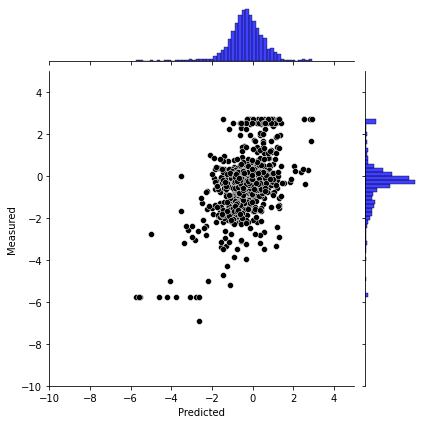

1.07062205738451


<Figure size 1080x1080 with 0 Axes>

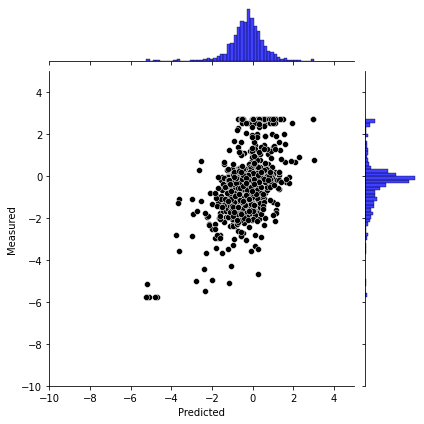

1.1054644594633973


<Figure size 1080x1080 with 0 Axes>

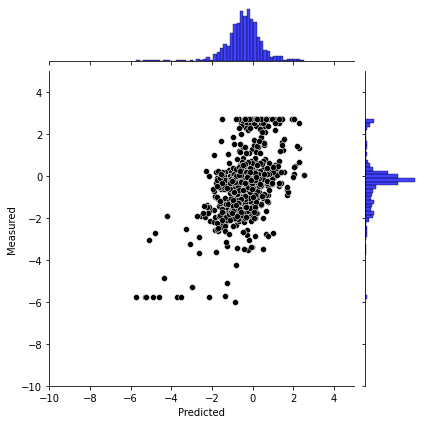

1.077218377419291


<Figure size 1080x1080 with 0 Axes>

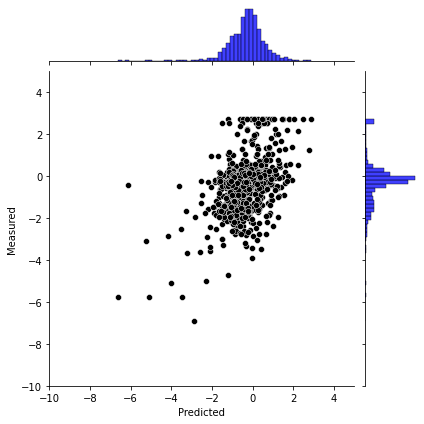

1.071216724267172


<Figure size 1080x1080 with 0 Axes>

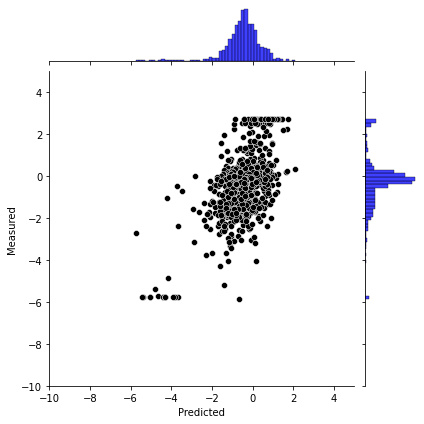

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
for i in range(5):
    save_model_name = f'models-regression-Malaria-TT1-new-{i+1}-50patience-full2'
    train_x, test_x, train_y, test_y = train_test_split(X, newY, test_size=0.1, random_state=42+i)
    model = build_model()
    model.load_weights(save_model_name)
    y_pred = model.predict([test_x])
    print(mean_squared_error(test_y, y_pred, squared=False))
    
    true = test_y
    pred = y_pred.reshape(-1)
    df = pd.DataFrame({
        'Measured': true,
        'Predicted': pred })

    # plt.style.use(['science','no-latex'])
    plt.figure(figsize=(15,15))
    plt.rcParams.update({'font.size': 10})
    gfg = sns.jointplot(x="Predicted", 
                  y="Measured", 
                  data=df,
                  # kind="reg",
                  color="k", xlim = (-10,5), ylim = (-10,5),
                  marginal_kws=dict(bins=50,color='b'));
    
    
    plt.savefig(f"Malaria_{i+1}_full.png")
    plt.show()

In [57]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr 
from scipy.stats import ttest_ind,ttest_rel
for i in range(5):
    save_model_name = f'models-regression-Malaria-TT1-new-{i+1}-50patience-full2'
    train_x, test_x, train_y, test_y = train_test_split(X, newY, test_size=0.1, random_state=42+i)
    model = build_model()
    model.load_weights(save_model_name)
    y_pred = model.predict([test_x])
    y_pred_train = model.predict([train_x])
    rmse_value = mean_squared_error(test_y, y_pred, squared=False)
    
    true = test_y
    pred = y_pred.reshape(-1)
    r2, q2, pearson_cc, p_value = r2_score(train_y,y_pred_train.reshape(-1)),r2_score(true,pred),pearsonr(true,pred)[0],ttest_rel(true,pred).pvalue
    print(r2,',',q2, ',',pearson_cc, ',',p_value)

0.7905692738637026 , 0.22137913874866388 , 0.5208520980415501 , 0.5248679523735071
0.793213922438835 , 0.24821338964432416 , 0.528518475580505 , 0.08575376098821504
0.8986107789542924 , 0.23397039621183668 , 0.5214735099152186 , 0.10870061593522308
0.799498606659121 , 0.1104169392993194 , 0.4600222177654538 , 0.04900816251089334
0.6515830780616887 , 0.332152170607127 , 0.5890346105691502 , 0.0007652438060843329


In [54]:
from scipy.stats import ttest_ind,t as tdist
r2_score(true,pred),pearsonr(true,pred),ttest_ind(true,pred),ttest_ind(true,pred,equal_var=False)

(0.332152170607127,
 (0.5890346105691502, 1.9305246233349013e-94),
 Ttest_indResult(statistic=2.274141831748206, pvalue=0.023063087240221096),
 Ttest_indResult(statistic=2.274141831748206, pvalue=0.023077937321455997))

In [77]:
ttest_rel([1,2,3,4,5,9],[1,2,3,4,6,8.1])

Ttest_relResult(statistic=-0.06788442333021281, pvalue=0.9485086862235093)

1.0983004704654746


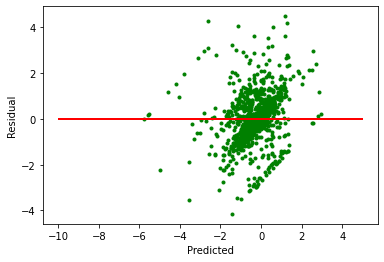

1.07062205738451


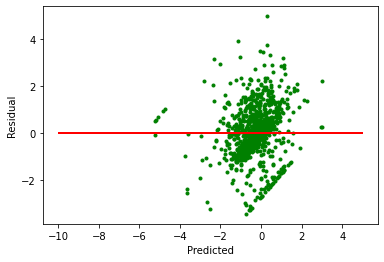

1.1054644594633973


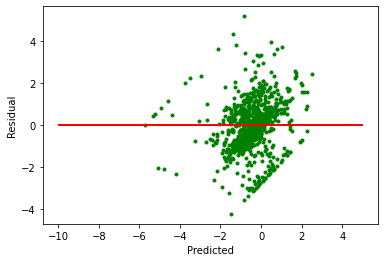

1.077218377419291


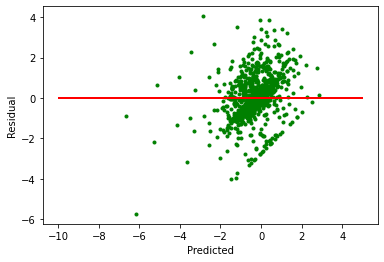

1.071216724267172


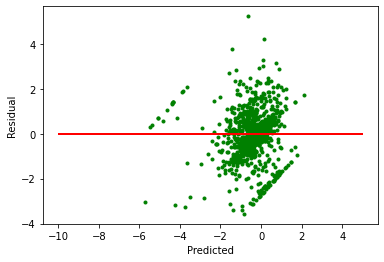

In [20]:
import numpy as np
import matplotlib.pyplot as plt
for i in range(5):
    save_model_name = f'models-regression-Malaria-TT1-new-{i+1}-50patience-full2'
    train_x, test_x, train_y, test_y = train_test_split(X, newY, test_size=0.1, random_state=42+i)
    model = build_model()
    model.load_weights(save_model_name)
    y_pred = model.predict([test_x])
    print(mean_squared_error(test_y, y_pred, squared=False))
    
    true = test_y
    pred = y_pred.reshape(-1)

    # plt.style.use(['science','no-latex'])
    # plt.figure(figsize=(15,15))
    plt.scatter(pred,pred-true,c="green",marker=".")
    plt.hlines(y=0,xmin=-10,xmax=5,lw=2,color="red")
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    
    plt.savefig(f"Malaria_{i+1}_full_res.png")
    plt.show()

In [12]:
# full bert-50patience
rmses,np.mean(rmses),np.std(rmses)

([1.0906717383405864,
  1.039610199156672,
  1.0188024725700227,
  1.0507646342970791,
  1.0545882846097991],
 1.050887465794832,
 0.023465391633369945)

In [10]:
# full bert-100patience
rmses,np.mean(rmses),np.std(rmses)

([1.0063580949428692,
  1.0851784973512246,
  1.0777485718667392,
  1.0589627862889464,
  1.0954081180099557],
 1.064731213691947,
 0.0315255808150387)

In [6]:
# full bert-25patience
rmses,np.mean(rmses),np.std(rmses)

([1.0724743672199366,
  1.0703952511101538,
  1.0377777908039216,
  1.0936139945967525,
  1.0322627015347063],
 1.0613048210530942,
 0.023014096696310063)

In [6]:
# new bert-25patience-90epoch
rmses,np.mean(rmses),np.std(rmses)

([1.0583950583121295,
  1.1173496507740501,
  1.0418018063461891,
  1.0346380118393677,
  0.9873146655023494],
 1.0478998385548173,
 0.041992978683314544)

In [27]:
# new bert-25patience
rmses,np.mean(rmses),np.std(rmses)

([1.0890491244200209,
  1.060300375637169,
  1.1112767571526938,
  1.0830738035265177,
  1.0843560422886345],
 1.0856112206050073,
 0.016243101797033522)

In [25]:
# new bert
rmses,np.mean(rmses),np.std(rmses)

([1.0209869003156773,
  1.0810810405728806,
  1.0654140548647733,
  1.1078819537348734,
  1.0398133985090816],
 1.0630354695994573,
 0.030495423274546213)

In [12]:
# old bert
rmses,np.mean(rmses),np.std(rmses)

([0.9916121076119483,
  1.0337316993661962,
  1.0829454142749573,
  1.0514002330609324,
  0.9876384854923529],
 1.0294655879612775,
 0.03617129430974601)